## Setup

In [1]:
import pandas as pd
from warnings import simplefilter

simplefilter(action="ignore", category=pd.errors.PerformanceWarning)
from pathlib import Path
import json
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt
from datetime import datetime
import re
from scipy import stats
import numpy as np
import statsmodels.api as sm
import statsmodels
from matplotlib import colormaps
from tqdm.notebook import tqdm
import helpers
from collections import defaultdict
from tqdm.notebook import tqdm


from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.regression.linear_model import OLS

from mri_data import file_manager as fm

### Load Data

In [2]:
drive_root = fm.get_drive_root()
dataroot = drive_root / "3Tpioneer_bids"
data_dir = Path("/home/srs-9/Projects/ms_mri/data")
fig_path = Path(
    "/home/srs-9/Projects/ms_mri/analysis/thalamus/figures_tables/sdmt_regressions"
)

choroid_volumes = pd.read_csv(
    "/home/srs-9/Projects/ms_mri/data/choroid_aschoplex_volumes.csv", index_col="subid"
)

ventricle_volumes = pd.read_csv(
    "/home/srs-9/Projects/ms_mri/analysis/paper1/data0/ventricle_volumes.csv",
    index_col="subid",
)
tiv = pd.read_csv("/home/srs-9/Projects/ms_mri/data/tiv_data.csv", index_col="subid")

df = pd.read_csv(
    "/home/srs-9/Projects/ms_mri/data/clinical_data_processed.csv", index_col="subid"
)
sdmt = pd.read_csv(
    "/home/srs-9/Projects/ms_mri/analysis/thalamus/SDMT_sheet.csv", index_col="subid"
)
df_thomas = pd.read_csv(data_dir / "hipsthomas_vols.csv", index_col="subid")

df = df.join([choroid_volumes, ventricle_volumes, tiv, sdmt['SDMT'], df_thomas['1-THALAMUS']])
df['SDMT'] = pd.to_numeric(df['SDMT'], errors='coerce')
df.rename(columns={'1-THALAMUS': 'whole_thalamus'}, inplace=True)

df_z = df.copy()
numeric_cols = df.select_dtypes(include='number').columns
df_z[numeric_cols] = df_z[numeric_cols].apply(stats.zscore, nan_policy="omit")

df_ms = df[df['dz_type2'] == "MS"]
df_ms_z = df_ms.copy()
df_ms_z[numeric_cols] = df_ms_z[numeric_cols].apply(stats.zscore, nan_policy="omit")

# assert df.loc[1340, 'EDSS'] == 2.5

viridis = colormaps['viridis'].resampled(20)

colors = helpers.get_colors()

In [3]:
df_thomas = pd.read_csv(data_dir / "hipsthomas_vols.csv", index_col="subid")
cols_orig = df_thomas.columns
new_colnames = {}
for col in df_thomas.columns:
    new_col = re.sub(r"(\d+)-([\w-]+)", r"\2_\1", col)
    new_col = re.sub("-", "_", new_col)
    new_colnames[col] = new_col
df_thomas = df_thomas.rename(columns=new_colnames)
df_thomas_norm = df_thomas.apply(lambda col: col / df_thomas['THALAMUS_1'])
df_thomas_z = df_thomas.apply(stats.zscore, nan_policy="omit")
df_thomas_norm_z = df_thomas_norm.apply(stats.zscore, nan_policy="omit")

df_thomas_left = pd.read_csv(data_dir / "hipsthomas_left_vols.csv", index_col="subid")
df_thomas_left = df_thomas_left.rename(columns=new_colnames)
df_thomas_left_norm = df_thomas_left.apply(lambda col: col / df_thomas['THALAMUS_1'])
df_thomas_left_z = df_thomas_left.apply(stats.zscore, nan_policy="omit")
df_thomas_left_norm_z = df_thomas_left_norm.apply(stats.zscore, nan_policy="omit")


df_thomas_right = pd.read_csv(data_dir / "hipsthomas_right_vols.csv", index_col="subid")
df_thomas_right = df_thomas_right.rename(columns=new_colnames)
df_thomas_right_norm = df_thomas_right.apply(lambda col: col / df_thomas['THALAMUS_1'])
df_thomas_right_z = df_thomas_right.apply(stats.zscore, nan_policy="omit")
df_thomas_right_norm_z = df_thomas_right_norm.apply(stats.zscore, nan_policy="omit")


thalamic_nuclei = [2, 4, 5, 6, 7, 8, 9, 10, 11, 12]
thalamic_nuclei_str = [str(i) for i in thalamic_nuclei]

hips_thomas_ref = pd.read_csv(
    "/home/srs-9/Projects/ms_mri/data/hipsthomas_struct_index.csv", index_col="index"
)['struct']
# hips_thomas_ref.rename(columns={"struct": "struct_name"}, inplace=True)

choroid_dists = pd.read_csv(data_dir / "centroid-choroid_centroid-left.csv", index_col="subid")
ventricle_dists = pd.read_csv(
    data_dir / "centroid-ventricle_SDT.csv", index_col="subid"
)

mni_choroid_dists = pd.read_csv("/home/srs-9/Projects/ms_mri/data/mni-centroid-choroid_SDT2.csv")

def combine_nuclei(df):
    df2 = pd.DataFrame()
    df2['anterior'] = df['AV_2']
    df2['ventral'] = df['VA_4'] + df['VLa_5'] + df['VLP_6'] + df['VPL_7']
    df2['intralaminar'] = df['CM_11'] 
    df2['medial'] = df['MD_Pf_12']
    df2['posterior'] = df['Pul_8'] + df['LGN_9'] + df['MGN_10']
    df2['THALAMUS_1'] = df['THALAMUS_1']
    return df2

df_thomas2 = combine_nuclei(df_thomas)
grouped_nuclei = df_thomas2.columns[~df_thomas2.columns.isin(["THALAMUS_1"])]
df_thomas2_z = df_thomas2.apply(stats.zscore, nan_policy="omit")
df_thomas2_norm = df_thomas2.apply(lambda col: col / df_thomas['THALAMUS_1'])
df_thomas2_norm_z = df_thomas2_norm.apply(stats.zscore, nan_policy="omit")

df_thomas2_left = combine_nuclei(df_thomas_left)
df_thomas2_left_z = df_thomas2_left.apply(stats.zscore, nan_policy="omit")
df_thomas2_norm_left = df_thomas2.apply(lambda col: col / df_thomas['THALAMUS_1'])
df_thomas2_norm_left_z = df_thomas2_norm_left.apply(stats.zscore, nan_policy="omit")

df_thomas2_right = combine_nuclei(df_thomas_right)
df_thomas2_right_z = df_thomas2_right.apply(stats.zscore, nan_policy="omit")
df_thomas2_norm_right = df_thomas2.apply(lambda col: col / df_thomas['THALAMUS_1'])
df_thomas2_norm_right_z = df_thomas2_norm_right.apply(stats.zscore, nan_policy="omit")

/home/srs-9/.virtualenvs/ms_mri/lib/python3.13/site-packages/pandas/core/apply.py:1081: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  results[i] = self.func(v, *self.args, **self.kwargs)
/home/srs-9/.virtualenvs/ms_mri/lib/python3.13/site-packages/pandas/core/apply.py:1081: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  results[i] = self.func(v, *self.args, **self.kwargs)
/home/srs-9/.virtualenvs/ms_mri/lib/python3.13/site-packages/pandas/core/apply.py:1081: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  results[i] = self.func(v, *self.args, **self.kwargs)
/home/srs-9/.virtualenvs/ms_mri/lib/python3.13/site-packag

### Functions

In [4]:
def plot_regression(
    data, predictor, outcome, covariates, xlabel=None, ylabel=None, title=None
):
    plus_covariates = ""
    if len(covariates) > 0:
        plus_covariates = f"+ {' + '.join(covariates)}"
    if xlabel is None:
        xlabel = predictor
    if ylabel is None:
        ylabel = outcome
    if title is None:
        title = f"{outcome} vs {predictor}"

    formula = f"{outcome} ~ {predictor} {plus_covariates}"
    res = sm.OLS.from_formula(formula, data=data).fit()
    x, y_pred, y_lims = helpers.get_regression_y(data, res, predictor, outcome)

    fig, axs = plt.subplot_mosaic(
        [['histx', '.'], ['scatter', 'histy']],
        figsize=(8, 6),
        width_ratios=(4, 1),
        height_ratios=(1, 4),
        layout='constrained',
    )

    helpers.scatter_hist(
        data[predictor],
        data[outcome],
        axs['scatter'],
        axs['histx'],
        axs['histy'],
        light_color=colors['light blue1'],
        dark_color=colors['dark blue1'],
    )

    axs['scatter'].plot(x, y_pred, color="black")
    axs['scatter'].fill_between(
        x, y_lims[0], y_lims[1], alpha=0.4, color=colors["light blue1"]
    )
    axs['scatter'].set_ylabel(ylabel)
    axs['scatter'].set_xlabel(xlabel)
    fig.suptitle(title)
    return fig, axs

## Assumption Checks

SDMT looks normal enough, probably don't need to test further

(array([  4.,  18.,  23.,  50.,  70., 110.,  95.,  50.,  25.,   9.]),
 array([11. , 18.6, 26.2, 33.8, 41.4, 49. , 56.6, 64.2, 71.8, 79.4, 87. ]),
 <BarContainer object of 10 artists>)

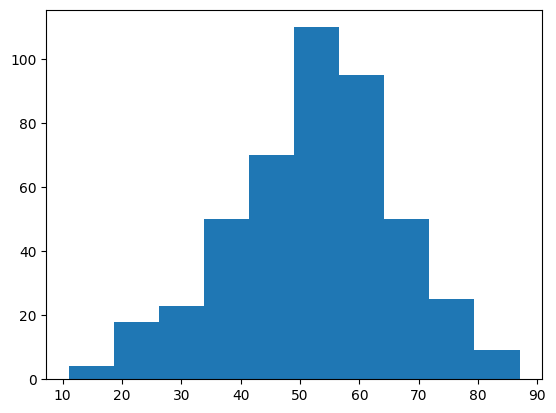

In [ ]:
plt.hist(df['SDMT'])

## Regressions

Regress SDMT against various MRI features independently

In [9]:
model_data = df_ms_z.join(df_thomas_z)
covariates = "age + Female + tiv"

outcome = "SDMT"
predictors = [
    "brain",
    "white",
    "grey",
    "cortical_thickness",
    "THALAMUS_1",
    "t2lv",
    "PRL",
    "choroid_volume",
    "ventricle_volume"
]

pvals = {}
coefs = {}
stderrs = {}
llci = {}
ulci = {}
r2 = {}
ci_str = {}

for x in predictors:
    formula = f"{outcome} ~ {x} + {covariates}"
    res = sm.OLS.from_formula(formula, data=model_data).fit()
    pvals[x] = res.pvalues[x]
    coefs[x] = res.params[x]
    stderrs[x] = res.HC0_se[x]
    ci = res.conf_int()
    llci[x] = ci.loc[x, 0]
    ulci[x] = ci.loc[x, 1]
    ci_str[x] = f"[{llci[x]:.6f}, {ulci[x]:.6f}]"
    r2[x] = res.rsquared_adj


regression_results = pd.DataFrame(
    {
        "coef": coefs,
        "stderr": stderrs,
        "llci": llci,
        "ulci": ulci,
        "pvals": pvals,
        "ci": ci_str,
    }
)
regression_results['p_fdr'] = stats.false_discovery_control(
    regression_results['pvals'], method='bh'
)
regression_results['R2'] = r2
regression_results.index.name = "structure"
regression_results.to_excel(fig_path / "SDMT_and_main_mri_features_MS.xlsx")
regression_results


,coef,stderr,llci,ulci,pvals,ci,p_fdr,R2
structure,,,,,,,,
brain,0.233121,0.046616,0.136631,0.329612,2.766091e-06,"[0.136631, 0.329612]",4.149137e-06,0.195320
white,0.104404,0.046018,0.013419,0.195390,2.460754e-02,"[0.013419, 0.195390]",2.460754e-02,0.164381
grey,0.291232,0.048228,0.190863,0.391600,2.143769e-08,"[0.190863, 0.391600]",3.858785e-08,0.211987
cortical_thickness,0.361019,0.047684,0.269593,0.452445,5.762797e-14,"[0.269593, 0.452445]",5.186517e-13,0.254860
THALAMUS_1,0.355909,0.054672,0.261354,0.450463,6.881416e-13,"[0.261354, 0.450463]",3.096637e-12,0.246721
t2lv,-0.266237,0.073334,-0.349392,-0.183082,7.447195e-10,"[-0.349392, -0.183082]",2.234158e-09,0.223395
PRL,-0.145967,0.047596,-0.233574,-0.058360,1.140599e-03,"[-0.233574, -0.058360]",1.390571e-03,0.174626
choroid_volume,-0.157975,0.055039,-0.253469,-0.062481,1.236063e-03,"[-0.253469, -0.062481]",1.390571e-03,0.174353
ventricle_volume,-0.284867,0.058036,-0.378444,-0.191289,4.496924e-09,"[-0.378444, -0.191289]",1.011808e-08,0.218472


### SDMT in PMS vs RMS

Patients with PMS had lower SDMT after adjusting for age, sex, and TIV

In [ ]:
model_data = df_ms_z.copy()
model_data = pd.concat(
    (model_data, pd.get_dummies(model_data['dz_type5'], dtype="int")), axis=1
)

formula = "PMS ~ SDMT + age + tiv + Female"
res = sm.Logit.from_formula(formula, data=model_data).fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:               thalamus   R-squared:                       0.374
Model:                            OLS   Adj. R-squared:                  0.367
Method:                 Least Squares   F-statistic:                     50.67
Date:                Sun, 29 Jun 2025   Prob (F-statistic):           8.12e-49
Time:                        12:10:39   Log-Likelihood:                -617.13
No. Observations:                 516   AIC:                             1248.
Df Residuals:                     509   BIC:                             1278.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             0.3197      0.11

## HIPS-THOMAS

### L/R for thalamus diagram

In [23]:
model_data = df_z.join(df_thomas_left_z)
model_data['whole_thalamus'] = df_thomas_z['THALAMUS_1']
model_data = model_data[model_data['dz_type5'].isin(["RMS", "PMS"])]
covariates = "age + Female + tiv"

pvals = {}
coefs = {}
stderrs = {}
llci = {}
ulci = {}
ci_str = {}
r2 = {}

outcome = "SDMT"

structs = thalamic_nuclei
all_results = {}
for x in structs:
    col = hips_thomas_ref[x]
    formula = f"{outcome} ~ {col} + {covariates}"
    res = sm.OLS.from_formula(formula, data=model_data).fit()
    all_results[col] = res
    pvals[col] = res.pvalues[col]
    coefs[col] = res.params[col]
    stderrs[col] = res.HC0_se[col]
    ci = res.conf_int()
    llci[col] = ci.loc[col, 0]
    ulci[col] = ci.loc[col, 1]
    ci_str[col] = f"[{llci[col]:.6f}, {ulci[col]:.6f}]"
    r2[col] = res.rsquared_adj

regression_results_left = pd.DataFrame({"coef": coefs, "pvals": pvals})
regression_results_left['p_fdr'] = stats.false_discovery_control(regression_results_left['pvals'], method='bh')
regression_results_left.sort_values(by="coef")

,coef,pvals,p_fdr
VA_4,0.150184,5.756337e-03,5.756337e-03
VLa_5,0.182403,5.701201e-04,6.334668e-04
LGN_9,0.231176,2.327372e-07,3.324818e-07
MGN_10,0.231338,4.946350e-06,6.182937e-06
VPL_7,0.260011,6.986023e-08,1.164337e-07
CM_11,0.281427,1.526962e-08,3.053924e-08
VLP_6,0.294166,2.479768e-09,6.199420e-09
AV_2,0.295640,9.007196e-10,3.002399e-09
MD_Pf_12,0.313821,1.556006e-11,7.780032e-11
Pul_8,0.318861,7.303905e-12,7.303905e-11


In [24]:
model_data = df_z.join(df_thomas_right_z)
model_data['whole_thalamus'] = df_thomas_z['THALAMUS_1']

model_data = model_data[model_data['dz_type5'].isin(["RMS", "PMS"])]
covariates = "age + Female + tiv"

pvals = {}
coefs = {}
stderrs = {}
llci = {}
ulci = {}
ci_str = {}
r2 = {}

outcome = "SDMT"

structs = thalamic_nuclei
all_results = {}
for x in structs:
    col = hips_thomas_ref[x]
    formula = f"{outcome} ~ {col} + {covariates}"
    res = sm.OLS.from_formula(formula, data=model_data).fit()
    all_results[col] = res
    pvals[col] = res.pvalues[col]
    coefs[col] = res.params[col]
    stderrs[col] = res.HC0_se[col]
    ci = res.conf_int()
    llci[col] = ci.loc[col, 0]
    ulci[col] = ci.loc[col, 1]
    ci_str[col] = f"[{llci[col]:.6f}, {ulci[col]:.6f}]"
    r2[col] = res.rsquared_adj

regression_results_right = pd.DataFrame({"coef": coefs, "pvals": pvals})
regression_results_right['p_fdr'] = stats.false_discovery_control(regression_results_right['pvals'], method='bh')
regression_results_right.sort_values(by="coef")
# regression_results_right

,coef,pvals,p_fdr
AV_2,0.197180,6.222051e-05,6.913390e-05
VLa_5,0.204489,9.919738e-05,9.919738e-05
MGN_10,0.214441,8.963291e-06,1.120411e-05
CM_11,0.225321,2.696347e-06,4.493912e-06
VA_4,0.243684,5.644092e-06,8.062989e-06
VPL_7,0.247819,1.430408e-07,2.860816e-07
MD_Pf_12,0.251695,4.703349e-08,1.175837e-07
LGN_9,0.274518,2.173656e-09,7.245521e-09
Pul_8,0.284878,7.780381e-10,3.890191e-09
VLP_6,0.306703,7.301572e-10,3.890191e-09


In [25]:
all_coefs = pd.concat([regression_results_left.coef, regression_results_right.coef])
bins = np.linspace(all_coefs.min()-0.0001, all_coefs.max()-0.0001, 10)
regression_results_left['coef_bin'] = np.digitize(regression_results_left['coef'], bins)
regression_results_right['coef_bin'] = np.digitize(regression_results_right['coef'], bins)
print(regression_results_left.sort_values(by="coef_bin")['coef_bin'])
print(regression_results_right.sort_values(by="coef_bin")['coef_bin'])
print(all_coefs.min()-0.0001, all_coefs.max()-0.0001)

VA_4         1
VLa_5        2
LGN_9        5
MGN_10       5
VPL_7        6
AV_2         8
VLP_6        8
CM_11        8
MD_Pf_12     9
Pul_8       10
Name: coef_bin, dtype: int64
AV_2        3
VLa_5       3
MGN_10      4
VA_4        5
CM_11       5
VPL_7       6
MD_Pf_12    6
LGN_9       7
Pul_8       8
VLP_6       9
Name: coef_bin, dtype: int64
0.15008371140886204 0.31876056420478394


In [18]:
bins

array([-0.28315051, -0.22823067, -0.17331083, -0.118391  , -0.06347116,
       -0.00855132,  0.04636851,  0.10128835,  0.15620819,  0.21112802])

In [26]:
model_data = df_z.join(df_thomas_left_z)
model_data['whole_thalamus'] = df_thomas_z['THALAMUS_1']
model_data = model_data[model_data['dz_type5'].isin(["RMS", "PMS"])]
covariates = "age + Female + tiv"

pvals = {}
coefs = {}
stderrs = {}
llci = {}
ulci = {}
ci_str = {}
r2 = {}

outcome = "EDSS_sqrt"

structs = thalamic_nuclei
all_results = {}
for x in structs:
    col = hips_thomas_ref[x]
    formula = f"{outcome} ~ {col}*dzdur + {covariates}"
    res = sm.OLS.from_formula(formula, data=model_data).fit()
    all_results[col] = res
    pvals[col] = res.pvalues[col]
    coefs[col] = res.params[col]
    stderrs[col] = res.HC0_se[col]
    ci = res.conf_int()
    llci[col] = ci.loc[col, 0]
    ulci[col] = ci.loc[col, 1]
    ci_str[col] = f"[{llci[col]:.6f}, {ulci[col]:.6f}]"
    r2[col] = res.rsquared_adj

regression_results_left = pd.DataFrame({"coef": coefs, "pvals": pvals})

model_data = df_z.join(df_thomas_right_z)
model_data['whole_thalamus'] = df_thomas_z['THALAMUS_1']

model_data = model_data[model_data['dz_type5'].isin(["RMS", "PMS"])]
covariates = "age + Female + tiv"

pvals = {}
coefs = {}
stderrs = {}
llci = {}
ulci = {}
ci_str = {}
r2 = {}

outcome = "EDSS_sqrt"

structs = thalamic_nuclei
all_results = {}
for x in structs:
    col = hips_thomas_ref[x]
    formula = f"{outcome} ~ {col}*dzdur + {covariates}"
    res = sm.OLS.from_formula(formula, data=model_data).fit()
    all_results[col] = res
    pvals[col] = res.pvalues[col]
    coefs[col] = res.params[col]
    stderrs[col] = res.HC0_se[col]
    ci = res.conf_int()
    llci[col] = ci.loc[col, 0]
    ulci[col] = ci.loc[col, 1]
    ci_str[col] = f"[{llci[col]:.6f}, {ulci[col]:.6f}]"
    r2[col] = res.rsquared_adj

regression_results_right = pd.DataFrame({"coef": coefs, "pvals": pvals})

EDSS_coefs = pd.concat([regression_results_left.coef, regression_results_right.coef])
SDMT_coefs = all_coefs

SignificanceResult(statistic=-0.4421052631578947, pvalue=0.005923797271372209)

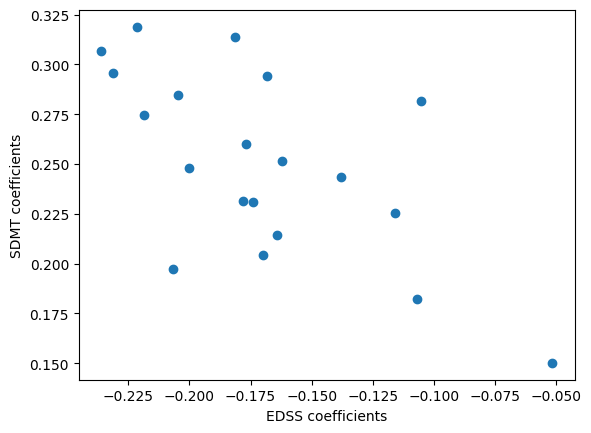

In [27]:
plt.scatter(EDSS_coefs, SDMT_coefs)
plt.xlabel("EDSS coefficients")
plt.ylabel("SDMT coefficients")
stats.kendalltau(EDSS_coefs, SDMT_coefs)

In [31]:
model_data = df_z.join(df_thomas_left_z)
model_data['whole_thalamus'] = df_thomas_z['THALAMUS_1']
model_data = model_data[model_data['dz_type5'].isin(["RMS", "PMS"])]
covariates = "age + Female + tiv"

pvals = {}
coefs = {}
stderrs = {}
llci = {}
ulci = {}
ci_str = {}
r2 = {}

outcome = "choroid_volume"

structs = thalamic_nuclei
all_results = {}
for x in structs:
    col = hips_thomas_ref[x]
    formula = f"{outcome} ~ {col} + {covariates}"
    res = sm.OLS.from_formula(formula, data=model_data).fit()
    all_results[col] = res
    pvals[col] = res.pvalues[col]
    coefs[col] = res.params[col]
    stderrs[col] = res.HC0_se[col]
    ci = res.conf_int()
    llci[col] = ci.loc[col, 0]
    ulci[col] = ci.loc[col, 1]
    ci_str[col] = f"[{llci[col]:.6f}, {ulci[col]:.6f}]"
    r2[col] = res.rsquared_adj

regression_results_left = pd.DataFrame({"coef": coefs, "pvals": pvals})

model_data = df_z.join(df_thomas_right_z)
model_data['whole_thalamus'] = df_thomas_z['THALAMUS_1']

model_data = model_data[model_data['dz_type5'].isin(["RMS", "PMS"])]
covariates = "age + Female + tiv"

pvals = {}
coefs = {}
stderrs = {}
llci = {}
ulci = {}
ci_str = {}
r2 = {}

outcome = "choroid_volume"

structs = thalamic_nuclei
all_results = {}
for x in structs:
    col = hips_thomas_ref[x]
    formula = f"{outcome} ~ {col} + {covariates}"
    res = sm.OLS.from_formula(formula, data=model_data).fit()
    all_results[col] = res
    pvals[col] = res.pvalues[col]
    coefs[col] = res.params[col]
    stderrs[col] = res.HC0_se[col]
    ci = res.conf_int()
    llci[col] = ci.loc[col, 0]
    ulci[col] = ci.loc[col, 1]
    ci_str[col] = f"[{llci[col]:.6f}, {ulci[col]:.6f}]"
    r2[col] = res.rsquared_adj

regression_results_right = pd.DataFrame({"coef": coefs, "pvals": pvals})

EDSS_coefs = pd.concat([regression_results_left.coef, regression_results_right.coef])
SDMT_coefs = all_coefs

SignificanceResult(statistic=-0.39999999999999997, pvalue=0.013532373706902114)

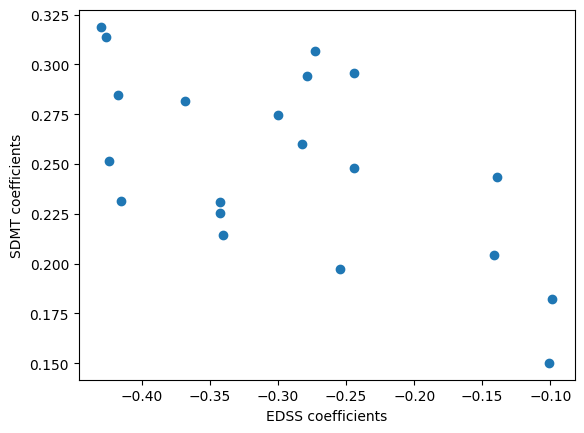

In [32]:
plt.scatter(EDSS_coefs, SDMT_coefs)
plt.xlabel("EDSS coefficients")
plt.ylabel("SDMT coefficients")
stats.kendalltau(EDSS_coefs, SDMT_coefs)

In [6]:
model_data = df_z.join(df_thomas_z)
model_data = model_data[model_data['dz_type5'].isin(["RMS", "PMS"])]
covariates = "age + Female + tiv + whole_thalamus"

pvals = {}
coefs = {}
stderrs = {}
llci = {}
ulci = {}
ci_str = {}
r2 = {}

outcome = "SDMT"

structs = thalamic_nuclei
all_results = {}
for x in structs:
    col = hips_thomas_ref[x]
    formula = f"{outcome} ~ {col} + {covariates}"
    res = sm.OLS.from_formula(formula, data=model_data).fit()
    all_results[col] = res
    pvals[col] = res.pvalues[col]
    coefs[col] = res.params[col]
    stderrs[col] = res.HC0_se[col]
    ci = res.conf_int()
    llci[col] = ci.loc[col, 0]
    ulci[col] = ci.loc[col, 1]
    ci_str[col] = f"[{llci[col]:.6f}, {ulci[col]:.6f}]"
    r2[col] = res.rsquared_adj



regression_results = pd.DataFrame({"coef": coefs, "stderr": stderrs, "llci": llci, "ulci": ulci, "pvals": pvals, "ci": ci_str})
regression_results['p_fdr'] = stats.false_discovery_control(
    regression_results['pvals'], method='bh'
)
regression_results['R2'] = r2
# regression_results.sort_values(by="coef", inplace=True, ascending=False)
# regression_results.to_excel(fig_path / "thalamic_nuclei.xlsx")
main_coefs = np.array([coefs[hips_thomas_ref[x]] for x in structs])

regression_results

,coef,stderr,llci,ulci,pvals,ci,p_fdr,R2
AV_2,0.070027,0.060509,-0.056104,0.196157,0.275812,"[-0.056104, 0.196157]",0.871044,0.247040
VA_4,-0.047190,0.072420,-0.183986,0.089607,0.498156,"[-0.183986, 0.089607]",0.871044,0.245813
VLa_5,0.010611,0.063001,-0.116062,0.137284,0.869313,"[-0.116062, 0.137284]",0.891808,0.245085
VLP_6,0.084425,0.084278,-0.100112,0.268961,0.369081,"[-0.100112, 0.268961]",0.871044,0.246399
VPL_7,0.015000,0.075449,-0.147584,0.177583,0.856206,"[-0.147584, 0.177583]",0.891808,0.245095
Pul_8,0.042615,0.120027,-0.202840,0.288070,0.733109,"[-0.202840, 0.288070]",0.891808,0.245236
LGN_9,0.091626,0.064214,-0.031831,0.215083,0.145386,"[-0.031831, 0.215083]",0.726932,0.248608
MGN_10,-0.047751,0.075635,-0.194426,0.098925,0.522627,"[-0.194426, 0.098925]",0.871044,0.245729
CM_11,0.097147,0.064898,-0.033441,0.227736,0.144442,"[-0.033441, 0.227736]",0.726932,0.248624
MD_Pf_12,-0.015177,0.120595,-0.234336,0.203983,0.891808,"[-0.234336, 0.203983]",0.891808,0.245071


In [11]:
model_data = df_z.join(df_thomas_z)
model_data = model_data[model_data['dz_type5'].isin(["RMS", "PMS"])]
covariates = "age + Female + tiv + THALAMUS_1"

pvals = {}
coefs = {}
stderrs = {}
llci = {}
ulci = {}
ci_str = {}
r2 = {}
thal_coefs = {}


outcome = "SDMT"

structs = thalamic_nuclei
all_results = {}
for x in structs:
    col = hips_thomas_ref[x]
    formula = f"{outcome} ~ {col} + {covariates}"
    res = sm.OLS.from_formula(formula, data=model_data).fit()
    pvals[col] = res.pvalues[col]
    coefs[col] = res.params[col]
    thal_coefs[col] = res.params['THALAMUS_1']
    stderrs[col] = res.HC0_se[col]
    ci = res.conf_int()
    llci[col] = ci.loc[col, 0]
    ulci[col] = ci.loc[col, 1]
    ci_str[col] = f"[{llci[col]:.6f}, {ulci[col]:.6f}]"
    r2[col] = res.rsquared_adj



regression_results = pd.DataFrame({"coef": coefs, "thal_coef": thal_coefs, "stderr": stderrs, "llci": llci, "ulci": ulci, "pvals": pvals, "ci": ci_str})
regression_results['p_fdr'] = stats.false_discovery_control(
    regression_results['pvals'], method='bh'
)
regression_results['R2'] = r2
regression_results.sort_values(by="coef", inplace=True, ascending=False)
regression_results.to_excel(fig_path / "thalamic_nuclei_thalamus_control.xlsx")
main_coefs = np.array([coefs[hips_thomas_ref[x]] for x in structs])

regression_results

,coef,thal_coef,stderr,llci,ulci,pvals,ci,p_fdr,R2
CM_11,0.097147,0.290097,0.064898,-0.033441,0.227736,0.144442,"[-0.033441, 0.227736]",0.726932,0.248624
LGN_9,0.091626,0.284003,0.064214,-0.031831,0.215083,0.145386,"[-0.031831, 0.215083]",0.726932,0.248608
VLP_6,0.084425,0.285348,0.084278,-0.100112,0.268961,0.369081,"[-0.100112, 0.268961]",0.871044,0.246399
AV_2,0.070027,0.309013,0.060509,-0.056104,0.196157,0.275812,"[-0.056104, 0.196157]",0.871044,0.247040
Pul_8,0.042615,0.313807,0.120027,-0.202840,0.288070,0.733109,"[-0.202840, 0.288070]",0.891808,0.245236
VPL_7,0.015000,0.343297,0.075449,-0.147584,0.177583,0.856206,"[-0.147584, 0.177583]",0.891808,0.245095
VLa_5,0.010611,0.350316,0.063001,-0.116062,0.137284,0.869313,"[-0.116062, 0.137284]",0.891808,0.245085
MD_Pf_12,-0.015177,0.370619,0.120595,-0.234336,0.203983,0.891808,"[-0.234336, 0.203983]",0.891808,0.245071
VA_4,-0.047190,0.383360,0.072420,-0.183986,0.089607,0.498156,"[-0.183986, 0.089607]",0.871044,0.245813
MGN_10,-0.047751,0.391878,0.075635,-0.194426,0.098925,0.522627,"[-0.194426, 0.098925]",0.871044,0.245729


In [14]:
model_data = df_z.join(df_thomas_norm_z)
model_data = model_data[model_data['dz_type5'].isin(["RMS", "PMS"])]
covariates = "age + Female + tiv"

pvals = {}
coefs = {}
stderrs = {}
llci = {}
ulci = {}
ci_str = {}
r2 = {}

outcome = "SDMT"

structs = thalamic_nuclei
all_results = {}
for x in structs:
    col = hips_thomas_ref[x]
    formula = f"{outcome} ~ {col} + {covariates}"
    res = sm.OLS.from_formula(formula, data=model_data).fit()
    all_results[col] = res
    pvals[col] = res.pvalues[col]
    coefs[col] = res.params[col]
    stderrs[col] = res.HC0_se[col]
    ci = res.conf_int()
    llci[col] = ci.loc[col, 0]
    ulci[col] = ci.loc[col, 1]
    ci_str[col] = f"[{llci[col]:.6f}, {ulci[col]:.6f}]"
    r2[col] = res.rsquared_adj



regression_results = pd.DataFrame({"coef": coefs, "stderr": stderrs, "llci": llci, "ulci": ulci, "pvals": pvals, "ci": ci_str})
regression_results['p_fdr'] = stats.false_discovery_control(
    regression_results['pvals'], method='bh'
)
regression_results['R2'] = r2
regression_results.sort_values(by="coef", inplace=True, ascending=False)
regression_results.to_excel(fig_path / "thalamic_nuclei_normed.xlsx")
main_coefs = np.array([coefs[hips_thomas_ref[x]] for x in structs])

regression_results

,coef,stderr,llci,ulci,pvals,ci,p_fdr,R2
Pul_8,0.211507,0.046717,0.128774,0.294240,7.311663e-07,"[0.128774, 0.294240]",2.437221e-06,0.199898
AV_2,0.179707,0.044493,0.088199,0.271215,1.302958e-04,"[0.088199, 0.271215]",3.257395e-04,0.182052
LGN_9,0.141220,0.045134,0.056109,0.226330,1.195274e-03,"[0.056109, 0.226330]",1.992124e-03,0.174467
MD_Pf_12,0.023327,0.051148,-0.060078,0.106731,5.828316e-01,"[-0.060078, 0.106731]",6.475907e-01,0.155485
VPL_7,-0.000106,0.043590,-0.086892,0.086680,9.980838e-01,"[-0.086892, 0.086680]",9.980838e-01,0.154917
CM_11,-0.047277,0.047470,-0.134602,0.040049,2.879188e-01,"[-0.134602, 0.040049]",3.598986e-01,0.157042
VLP_6,-0.097542,0.047098,-0.186188,-0.008896,3.110758e-02,"[-0.186188, -0.008896]",4.443939e-02,0.163628
MGN_10,-0.173844,0.048533,-0.264161,-0.083526,1.761021e-04,"[-0.264161, -0.083526]",3.522042e-04,0.181017
VLa_5,-0.260050,0.045164,-0.343387,-0.176712,1.898524e-09,"[-0.343387, -0.176712]",9.492619e-09,0.220229
VA_4,-0.290551,0.043321,-0.373023,-0.208078,1.529368e-11,"[-0.373023, -0.208078]",1.529368e-10,0.236437


In [8]:
model_data = df_z.join(df_thomas2_z)
model_data['THALAMUS_1'] = df_thomas_z['THALAMUS_1']
model_data = model_data[model_data['dz_type5'].isin(["PMS"])]
covariates = "age + Female + tiv"

pvals = {}
coefs = {}
stderrs = {}
llci = {}
ulci = {}
ci_str = {}
r2 = {}

outcome = "SDMT"

structs = ["anterior", "medial", "ventral", "posterior", "THALAMUS_1"]
all_results = {}
for x in structs:
    col = x
    formula = f"{outcome} ~ {col} + {covariates}"
    res = sm.OLS.from_formula(formula, data=model_data).fit()
    all_results[col] = res
    pvals[col] = res.pvalues[col]
    coefs[col] = res.params[col]
    stderrs[col] = res.HC0_se[col]
    ci = res.conf_int()
    llci[col] = ci.loc[col, 0]
    ulci[col] = ci.loc[col, 1]
    ci_str[col] = f"[{llci[col]:.6f}, {ulci[col]:.6f}]"
    r2[col] = res.rsquared_adj



regression_results = pd.DataFrame({"coef": coefs, "stderr": stderrs, "llci": llci, "ulci": ulci, "pvals": pvals, "ci": ci_str})
regression_results['p_fdr'] = stats.false_discovery_control(
    regression_results['pvals'], method='bh'
)
regression_results['R2'] = r2
regression_results.sort_values(by="coef", inplace=True, ascending=False)
# regression_results.to_excel(fig_path / "thalamic_nuclei_normed.xlsx")
main_coefs = np.array([coefs[x] for x in structs])

regression_results

,coef,stderr,llci,ulci,pvals,ci,p_fdr,R2
ventral,0.510896,0.089394,0.325497,0.696295,3.993735e-07,"[0.325497, 0.696295]",0.000002,0.239916
THALAMUS_1,0.458254,0.085655,0.278900,0.637609,2.089651e-06,"[0.278900, 0.637609]",0.000005,0.212057
posterior,0.400844,0.090611,0.219874,0.581814,2.983040e-05,"[0.219874, 0.581814]",0.000050,0.165495
medial,0.316770,0.079956,0.138150,0.495390,6.741073e-04,"[0.138150, 0.495390]",0.000843,0.108285
anterior,0.273957,0.124839,0.013516,0.534397,3.946197e-02,"[0.013516, 0.534397]",0.039462,0.031419


In [9]:
model_data = df_z.join(df_thomas2_z)
model_data['THALAMUS_1'] = df_thomas_z['THALAMUS_1']
model_data = model_data[model_data['dz_type5'].isin(["PMS"])]
covariates = "age + Female + tiv + THALAMUS_1"

pvals = {}
coefs = {}
stderrs = {}
llci = {}
ulci = {}
ci_str = {}
r2 = {}

outcome = "SDMT"

structs = ["anterior", "medial", "ventral", "posterior"]
all_results = {}
for x in structs:
    col = x
    formula = f"{outcome} ~ {col} + {covariates}"
    res = sm.OLS.from_formula(formula, data=model_data).fit()
    all_results[col] = res
    pvals[col] = res.pvalues[col]
    coefs[col] = res.params[col]
    stderrs[col] = res.HC0_se[col]
    ci = res.conf_int()
    llci[col] = ci.loc[col, 0]
    ulci[col] = ci.loc[col, 1]
    ci_str[col] = f"[{llci[col]:.6f}, {ulci[col]:.6f}]"
    r2[col] = res.rsquared_adj



regression_results = pd.DataFrame({"coef": coefs, "stderr": stderrs, "llci": llci, "ulci": ulci, "pvals": pvals, "ci": ci_str})
regression_results['p_fdr'] = stats.false_discovery_control(
    regression_results['pvals'], method='bh'
)
regression_results['R2'] = r2
regression_results.sort_values(by="coef", inplace=True, ascending=False)
# regression_results.to_excel(fig_path / "thalamic_nuclei_normed.xlsx")
main_coefs = np.array([coefs[x] for x in structs])

regression_results

,coef,stderr,llci,ulci,pvals,ci,p_fdr,R2
ventral,0.397408,0.191871,-0.018452,0.813268,0.060826,"[-0.018452, 0.813268]",0.121651,0.234478
posterior,-0.147065,0.240074,-0.641007,0.346876,0.555574,"[-0.641007, 0.346876]",0.555574,0.206261
anterior,-0.171250,0.138368,-0.472975,0.130476,0.262419,"[-0.472975, 0.130476]",0.349892,0.214460
medial,-0.430576,0.207274,-0.828286,-0.032866,0.034175,"[-0.828286, -0.032866]",0.121651,0.242928


In [6]:
model_data['anterior']

subid
1001   -0.462497
1002    1.032197
1003   -0.694128
1004    0.151577
1005   -1.076596
          ...   
3016   -1.598034
3017    0.058699
3021   -1.343117
3023   -0.172775
3028   -0.508866
Name: anterior, Length: 468, dtype: float64